In [1]:
import numpy as np
import setting 
setting.load()
import noc
from scipy.linalg import expm
from scipy.integrate import odeint
from noc.gramians import ctrl 
from noc.simulate import impulse
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import noc.plotting as plotting
plotting.load()

In [2]:
n = 3
w = np.array([[ 0., 4., 20.],
              [-4., 0.,  0.],
              [ 0., 0.,  0.]])
a = w - np.eye(n)
at = a.T
duration = 1.
dt = 1e-3
ts = np.linspace(0,duration, int(duration/ dt) + 1)

In [3]:
# finite-time controllability Gramian 
def finite_time_ctrl_gramian(a,b=None):
    n = np.shape(a)[0]
    at = a.T
    bbt = np.eye(n) if b is None else b.dot(b.T)
    def f(p,t): 
        p = p.reshape(n,n)
        dp = a.dot(p) + p.dot(at) + bbt 
        return dp.reshape(-1,)
    g = odeint(f, np.zeros(n*n), np.linspace(0,duration,2))
    return g[-1].reshape(n,n)
 
p = finite_time_ctrl_gramian(a)
pinv = np.linalg.inv(p)
    
def optimal_input(target):
  def f(x, t):  
    return - at.dot(x)
  prefactor = expm(duration * at)
  u0 = prefactor.dot(pinv).dot(target)
  return odeint(f,u0,ts,tcrit=ts)

def simulate(inp):
  def f(x, t):
    inpx = inp[int(t/dt),:]
    return a.dot(x) + inpx
  return odeint(f, np.zeros(n), ts, tcrit=ts) 

In [4]:
def do_for(target):
  u = optimal_input(target)
  x = simulate(u)
  target = target.T
  return {"u":u, "x": x, "target": target}

u, _, _ = np.linalg.svd(ctrl(a)) 
results = [do_for(-target) if (i==0) else do_for(target) for i, target in enumerate(u.T)]

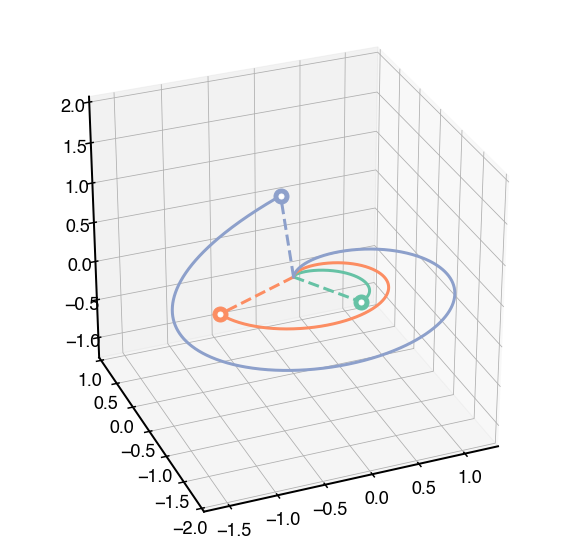

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_alpha(0)
ax.set_xlim(-1.7,1.3)
ax.set_ylim(-2.,1.)
ax.set_zlim(-1.2,2.)
ax.view_init(30,248)
for i, r in enumerate(results):
    x = r["x"]
    target = r["target"]
    ax.plot(x[:,0],x[:,1],x[:,2], color=plt.cm.Set2((i+1)/10), linewidth=3)
    ax.plot([0,target[0]],[0,target[1]],[0,target[2]], "--", color=plt.cm.Set2((i+1)/10), linewidth=3)
    ax.plot([target[0]], [target[1]], [target[2]], "bo", color=plt.cm.Set2((i+1)/10), markersize=15)
    ax.plot([target[0]], [target[1]], [target[2]], "bo", color="white", markersize=5)
plt.show()

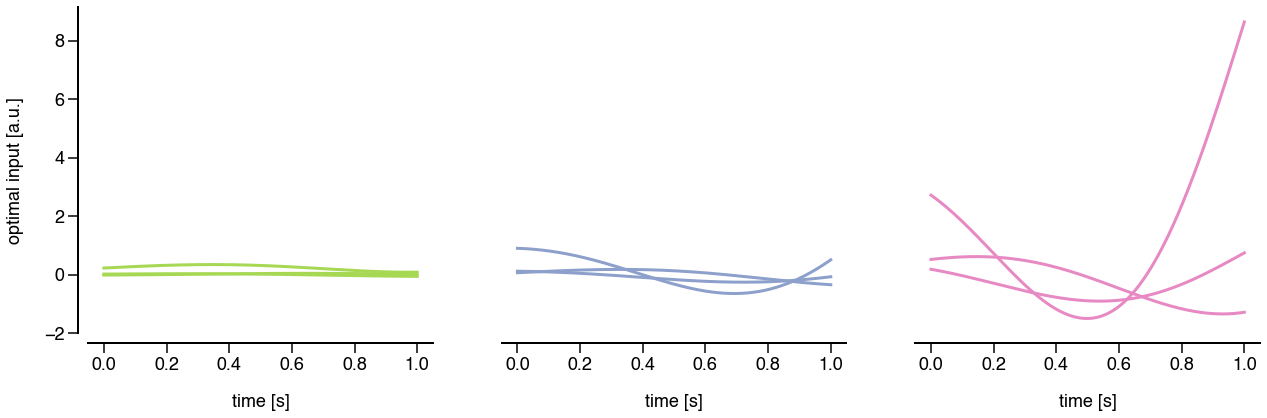

In [6]:
fig = plt.figure(figsize=(n*7, 6))
fig.patch.set_alpha(0)
axes = fig.subplots(1,n,sharey=True)
axes[0].set_ylabel("optimal input [a.u.]")
colors = [6,3,4]
for i, ax in enumerate(axes):
    plotting.adjust_spines(ax.spines,smart_bounds=False)
    if i > 0:
        ax.tick_params(axis='y', which='both',length=0)
        ax.spines["left"].set_visible(False)
    ax.set_xlabel("time [s]")
    u = results[i]["u"]
    for j in range(3):
        ax.plot(ts,u[:,j],color=plt.cm.Set2(colors[i]/10),linewidth=3)
plt.show()

In [7]:
# save sample from stationary distribution
p = ctrl(a)
u, s, _ = np.linalg.svd(p)
ell = u * np.sqrt(s).reshape(1,-1)
samples = ell.dot(np.random.randn(n,900)).T

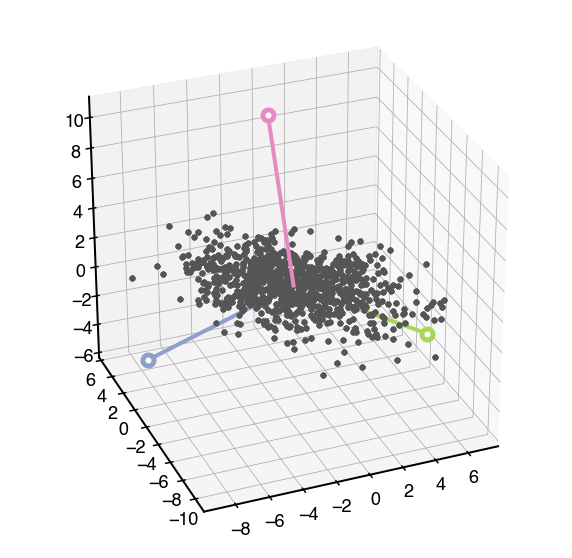

In [8]:

fig = plt.figure(figsize=(10,10))
fig.patch.set_alpha(0)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-9.5,7.5)
ax.set_ylim(-11,6)
ax.set_zlim(-6,11)
ax.view_init(30,248)
colors = [6,3,4]
for i, r in enumerate(results):
    target = r["target"] * 11 
    ax.plot(samples[:,0],samples[:,1],samples[:,2], ".", color="#555555", markersize=10)
    ax.plot([0,target[0]],[0,target[1]],[0,target[2]], color=plt.cm.Set2(colors[i] / 10), linewidth=4)
    ax.plot([target[0]], [target[1]], [target[2]], "o", color=plt.cm.Set2(colors[i] / 10), markersize=15)
    ax.plot([target[0]], [target[1]], [target[2]], "o", color="white", markersize=5)
plt.show()